<a href="https://colab.research.google.com/github/ugursirvermez/PyTorch_Education/blob/main/12_pytorch_foodvision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#KURULUM

In [1]:
# torch 1.12+ ve torchvision 0.13+ üzeri olmalı
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version 1.12+ üzeri olmalı"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision 0.13+ üzeri olmalı"
    print(f"torch: {torch.__version__}")
    print(f"torchvision: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision en güncel sürümü ile yükleniyor...")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch: {torch.__version__}")
    print(f"torchvision: {torchvision.__version__}")

import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Trochinfo Kurulumu
try:
    from torchinfo import summary
except:
    print("[INFO] Torchinfo bulunamadı, yükleniyor...")
    !pip install -q torchinfo
    from torchinfo import summary

# Github'tan dosyalar indirilsin.
try:
    from Module_Files import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Module_Files adlı dosyalar
    print("[INFO] Github dosyaları indiriliyor.")
    !git clone https://github.com/ugursirvermez/PyTorch_Education/
    !mv PyTorch_Education/Module_Files .
    !rm -rf PyTorch_Education
    from Module_Files import data_setup, engine

    # MRDBOURKE'un Helper_Functions'ı
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # Helper_Functions by mrdbourke
    !rm -rf pytorch-deep-learning
    from helper_functions import download_data, set_seeds, plot_loss_curves


[INFO] torch/torchvision en güncel sürümü ile yükleniyor...
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
torch: 2.6.0+cu124
torchvision: 0.21.0+cu124
data/pizza_steak_sushi dosya zaten var.
İndiriliyor...
Sıkıştırılmış dosyada çıkarılıyor...
Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
%%writefile demo/foodvision_big/model.py
#EffnetB2 Modeli Oluşturma
def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):

    # 1, 2, 3. EffNetB2 eğitilmiş weights, transforms ve model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # 4. Temel Katmanları Dondurma
    for param in model.parameters():
        param.requires_grad = False

    # 5. Tekrarlanabilirlik için sınıflandırma başlığını rastgele seed atma
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )

    return model, transforms

Overwriting demo/foodvision_big/model.py


In [4]:
#EffnetB2 Modeli Oluşturma
def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):

    # 1, 2, 3. EffNetB2 eğitilmiş weights, transforms ve model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # 4. Temel Katmanları Dondurma
    for param in model.parameters():
        param.requires_grad = False

    # 5. Tekrarlanabilirlik için sınıflandırma başlığını rastgele seed atma
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )

    return model, transforms

In [5]:
# EffNetB2 modeli 101 sınıflı -> Food101
effnetb2_food101, effnetb2_transforms = create_effnetb2_model(num_classes=101)

# # Modeli yazdıralım.
summary(effnetb2_food101,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 101]             --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [6]:
# Food101 eğitimi için transform'lar
food101_train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.TrivialAugmentWide(),
    effnetb2_transforms,
])

print(f"Training transforms:\n{food101_train_transforms}\n")
print(f"Testing transforms:\n{effnetb2_transforms}")

Training transforms:
Compose(
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)
)

Testing transforms:
ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


In [7]:
from torchvision import datasets

# Verileri saklayacağımız bir yol oluşturalım.
from pathlib import Path
data_dir = Path("data")

# Eğtilmiş veriyi alalım (~750 resim x 101 etiket)
train_data = datasets.Food101(root=data_dir, # dosyaların indirileceği klasör
                              split="train", # dataseti ayıracak etiket
                              transform=food101_train_transforms, # tansform
                              download=True) # indirmek istiyor muyuz?

# Test edilecek veriyi alalım (~250 resim x 101 etiket)
test_data = datasets.Food101(root=data_dir,
                             split="test",
                             transform=effnetb2_transforms, #EffNetB2 transform
                             download=True)

100%|██████████| 5.00G/5.00G [04:33<00:00, 18.3MB/s]


In [8]:
# Food101 veri setindeki etiketlere bakalım
food101_class_names = train_data.classes

# İlk 10 taneyi yazdıralım.
food101_class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [9]:
# %80 eğitilmiş, %20 test verisi olarak ikiye ayıralım:
def split_dataset(dataset:torchvision.datasets, split_size:float=0.2, seed:int=42):

    # Orijinal veri setinin uzunluğuna göre veri setini istenilen boyutta ayıralım.
    length_1 = int(len(dataset) * split_size) # istenilen uzunluk
    length_2 = len(dataset) - length_1 # geriye kalan uzunluk

    # Yazdır
    print(f"[INFO] Veri Setinin uzunluğu: {len(dataset)} paylar olarak ayrılan uzunluklar: {length_1} ({int(split_size*100)}%), {length_2} ({int((1-split_size)*100)}%)")

    # Rasgele seed ile iki gruba ayırma
    random_split_1, random_split_2 = torch.utils.data.random_split(dataset,
                                                                   lengths=[length_1, length_2],
                                                                   generator=torch.manual_seed(seed)) # random seed
    return random_split_1, random_split_2

In [10]:
# Eğitilmiş 20% split of Food101
train_data_food101_80_percent, _ = split_dataset(dataset=train_data,
                                                 split_size=0.8)

# Test Edilecek 20% split of Food101
test_data_food101_20_percent, _ = split_dataset(dataset=test_data,
                                                split_size=0.2)

len(train_data_food101_80_percent), len(test_data_food101_20_percent)

[INFO] Veri Setinin uzunluğu: 75750 paylar olarak ayrılan uzunluklar: 60600 (80%), 15150 (19%)
[INFO] Veri Setinin uzunluğu: 25250 paylar olarak ayrılan uzunluklar: 5050 (20%), 20200 (80%)


(60600, 5050)

In [11]:
import os
import torch

BATCH_SIZE = 32
NUM_WORKERS = 2 if os.cpu_count() <= 4 else 4 # Google Colab'in 2 İşlemcisi olduğu için bu şekilde

# Food101 %80 eğitilmiş DataLoader'ı
train_dataloader_food101_80_percent = torch.utils.data.DataLoader(train_data_food101_80_percent,
                                                                  batch_size=BATCH_SIZE,
                                                                  shuffle=True,
                                                                  num_workers=NUM_WORKERS)
# Food101 %20 test edilecek DataLoader'ı
test_dataloader_food101_20_percent = torch.utils.data.DataLoader(test_data_food101_20_percent,
                                                                 batch_size=BATCH_SIZE,
                                                                 shuffle=False,
                                                                 num_workers=NUM_WORKERS)

In [12]:
from Module_Files import engine

# Optimizer
optimizer = torch.optim.Adam(params=effnetb2_food101.parameters(),
                             lr=1e-3)

# Loss fonksiyonu
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

# En az %56 başarısı olduğu araştırma çalışmasında yer alıyor.
set_seeds()
effnetb2_food101_results = engine.train(model=effnetb2_food101,
                                        train_dataloader=train_dataloader_food101_80_percent,
                                        test_dataloader=test_dataloader_food101_20_percent,
                                        optimizer=optimizer,
                                        loss_fn=loss_fn,
                                        epochs=5,
                                        device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.0468 | train_acc: 0.3939 | test_loss: 2.2415 | test_acc: 0.5978
Epoch: 2 | train_loss: 2.6614 | train_acc: 0.4785 | test_loss: 2.1513 | test_acc: 0.6205
Epoch: 3 | train_loss: 2.6164 | train_acc: 0.4889 | test_loss: 2.1182 | test_acc: 0.6270
Epoch: 4 | train_loss: 2.5864 | train_acc: 0.4967 | test_loss: 2.1019 | test_acc: 0.6329
Epoch: 5 | train_loss: 2.5719 | train_acc: 0.5034 | test_loss: 2.0905 | test_acc: 0.6384


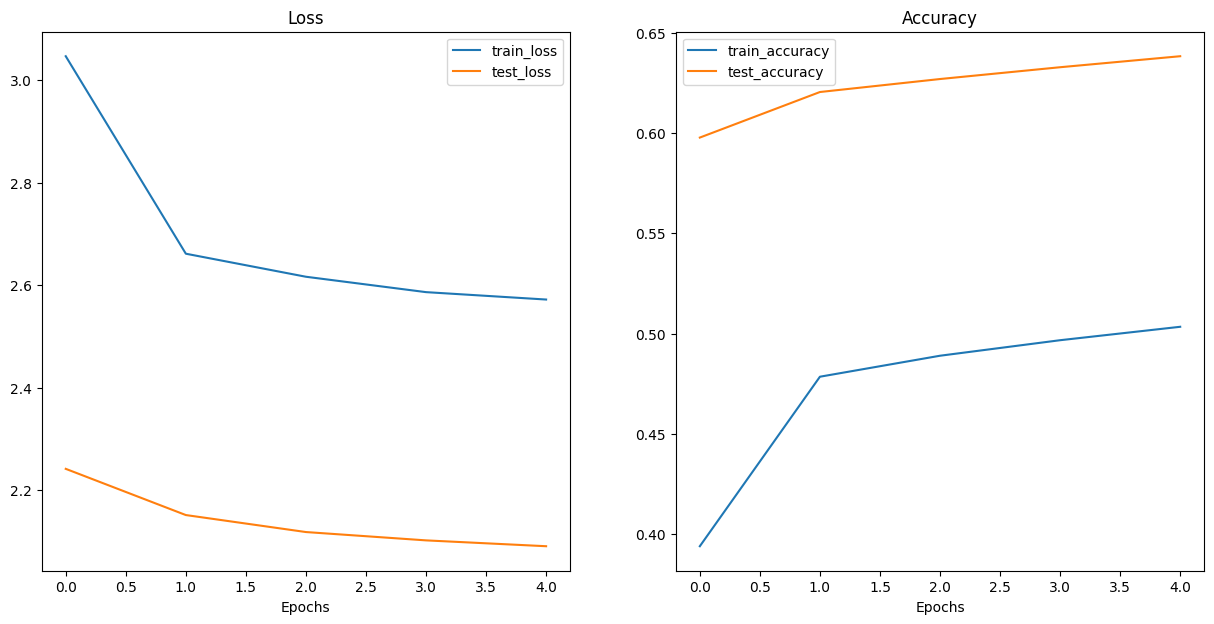

In [13]:
from helper_functions import plot_loss_curves

# FoodVision için Eğriye Bakalım
plot_loss_curves(effnetb2_food101_results)

In [14]:
from Module_Files import utils

# model yolu
effnetb2_food101_model_path = "11_pretrained_effnetb2_food101.pth"

# FoodVision modelini kaydet
utils.save_model(model=effnetb2_food101,
                 target_dir="models",
                 model_name=effnetb2_food101_model_path)

[INFO] Modelin Kaydedildiği Yer: models/11_pretrained_effnetb2_food101.pth


In [15]:
from pathlib import Path
# Food101  EffNetB2 değişkeni oluşturalım
loaded_effnetb2_food101, effnetb2_transforms = create_effnetb2_model(num_classes=101)

# Oluşan değişken ile modelin state_dict() parametresini kullanalım
loaded_effnetb2_food101.load_state_dict(torch.load("models/11_pretrained_effnetb2_food101.pth"))

# Modelin boyutunu megabayt cinsinden olçelim.
pretrained_effnetb2_food101_model_size = Path("models", effnetb2_food101_model_path).stat().st_size // (1024*1024)
print(f"EffNetB2 Food101 model boyutu: {pretrained_effnetb2_food101_model_size} MB")

EffNetB2 Food101 model boyutu: 30 MB


In [18]:
from pathlib import Path
import shutil

# FoodVision Big Demo Dosya Yolu
foodvision_big_demo_path = Path("demo/foodvision_big/")

# FoodVision Big demo klasör yolu
foodvision_big_demo_path.mkdir(parents=True, exist_ok=True)

# FoodVision Big demo örnekler klasörü oluşturuyoruz
(foodvision_big_demo_path / "examples").mkdir(parents=True, exist_ok=True)

#Resimleri klasöre yükleyelim:
foodvision_examples = [Path('data/pizza_steak_sushi/test/sushi/1172255.jpg'),
                            Path('data/pizza_steak_sushi/test/steak/100274.jpg'),
                            Path('data/pizza_steak_sushi/test/pizza/1152100.jpg')]

# örnek resmin kopyasını gömelim.
for example in foodvision_examples:
    destination = foodvision_big_demo_path /"examples"/ example.name
    print(f"[INFO] Kopyala {example} to {destination}")
    shutil.copy2(src=example, dst=destination)

# Önceden yollanan modeli bulamazsa bu işlem yapılmasın.
!mv models/11_pretrained_effnetb2_food101.pth demo/foodvision_big

[INFO] Kopyala data/pizza_steak_sushi/test/sushi/1172255.jpg to demo/foodvision_big/examples/1172255.jpg
[INFO] Kopyala data/pizza_steak_sushi/test/steak/100274.jpg to demo/foodvision_big/examples/100274.jpg
[INFO] Kopyala data/pizza_steak_sushi/test/pizza/1152100.jpg to demo/foodvision_big/examples/1152100.jpg


In [19]:
# Food101 sınıf isimleri metni oluşturma
foodvision_big_class_names_path = foodvision_big_demo_path / "class_names.txt"

# Food101'deki bütün isimleri metin belgesine yaz.
with open(foodvision_big_class_names_path, "w") as f:
    print(f"[INFO] Food101 Sınıf isimleri {foodvision_big_class_names_path} yazıldı...")
    f.write("\n".join(food101_class_names)) # her birini alt alta yaz \n ile

[INFO] Food101 Sınıf isimleri demo/foodvision_big/class_names.txt yazıldı...


In [28]:
with open(foodvision_big_class_names_path, "r") as f:
    food101_class_names_loaded = [food.strip() for food in  f.readlines()]

food101_class_names_loaded[:5]

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare']

In [25]:
%%writefile demo/foodvision_big/app.py
### 1. Kütüphaneler ve dosyaları dahil edelim.###
import gradio as gr
import os
import torch
import torchvision

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Sınıf isimlerini çağıralım
with open("class_names.txt", "r") as f: # reading them in from class_names.txt
    class_names = [food_name.strip() for food_name in  f.readlines()]

### 2. Modeli ve transformları doldurlaım ###

# Model
effnetb2, effnetb2_transforms = create_effnetb2_model(
    num_classes=101, # could also use len(class_names)
)

# Verileri yükleme (Weights)
effnetb2.load_state_dict(
    torch.load(
        f="11_pretrained_effnetb2_food101.pth",
        map_location=torch.device("cpu"),  # load to CPU
    )
)

### 3. Tahmin yürütme ###
def predict(img) -> Tuple[Dict, float]:

    # Zsmanlayıcıyı başlat
    start_time = timer()

    # Transform'a batch ekle
    img = effnetb2_transforms(img).unsqueeze(0)

    # Veriyi modele at.
    effnetb2.eval()
    with torch.inference_mode():
        # Olasılıkları geçir
        pred_probs = torch.softmax(effnetb2(img), dim=1)

    # Etiket tahminlerine bak
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    # Ortalama zaman jesaplama
    pred_time = round(timer() - start_time, 5)

    # Tahmini ve olasılığı geri döndür.
    return pred_labels_and_probs, pred_time

### 4. Gradio Uygulaması ###
title = "FoodVision101 🍔👁"
description = "EfficientNetB2 ve PyTorch'taki food101 veri setinin kullanımını içeren programdır. Burada Veri seti ve model testi yapılmıştır. Eğitim amaçlı olup Uğur Sırvermez tarafından oluşturuldu. [101 sınıfın listesi:](https://github.com/ugursirvermez/PyTorch_Education/blob/main/Module_Files/food101_class_names.txt)."
article = "Esinlenilen makale: [09. PyTorch Model Deployment](https://github.com/mrdbourke/pytorch-deep-learning/tree/main)."

# Örnekler
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Gradio UI
demo = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil"),
    outputs=[
        gr.Label(num_top_classes=5, label="Tahminler"),
        gr.Number(label="Tahmin Süresi (s)"),
    ],
    examples=example_list,
    title=title,
    description=description,
    article=article,
)

# Uygulamayı Yayınlama
demo.launch()


Overwriting demo/foodvision_big/app.py


In [21]:
%%writefile demo/foodvision_big/requirements.txt
pip==23.3.1
pandas==2.2.3
numpy==1.26.4
torch==1.12.0
torchvision==0.13.0
gradio==5.17.1

Writing demo/foodvision_big/requirements.txt


In [23]:
# Zip haline dosyaları indirelim.
!cd demo/foodvision_big && zip -r ../foodvision_big.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

# Google Colab'te çalışma durumu için
try:
    from google.colab import files
    files.download("demo/foodvision_big.zip")
except:
    print("Google Colab error")

  adding: 11_pretrained_effnetb2_food101.pth (deflated 8%)
  adding: app.py (deflated 48%)
  adding: class_names.txt (deflated 48%)
  adding: examples/ (stored 0%)
  adding: examples/1172255.jpg (deflated 0%)
  adding: examples/1152100.jpg (deflated 0%)
  adding: examples/100274.jpg (deflated 1%)
  adding: model.py (deflated 44%)
  adding: requirements.txt (deflated 12%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [26]:
# IPython ile Arayüz
from IPython.display import IFrame

# FoodVision
IFrame(src="https://hf.space/embed/ugursirvermez/foodvision101/+", width=900, height=750)